In [2]:
import os
import glob
import string
import warnings
import pandas as pd
import numpy as np
from itertools import product

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.legend import Legend
from matplotlib.colors import rgb2hex, hex2color
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.gridspec import GridSpecFromSubplotSpec

from colorspacious import cspace_convert
import seaborn as sns
import cmocean

from IPython.display import display, HTML

warnings.filterwarnings('ignore')

In [3]:
SCALE_FACTOR = 1.25
SCALE_FACTOR_SNS = 1.2

mpl.rcParams['xtick.major.width'] = 0.25
mpl.rcParams['ytick.major.width'] = 0.25
mpl.rcParams['grid.linewidth'] = 0.25

mpl.rcParams['figure.facecolor'] = (1,1,1,1)
mpl.rcParams['figure.dpi'] = 600 * SCALE_FACTOR * 0.8

mpl.rcParams['axes.labelsize'] = 8 * SCALE_FACTOR * 0.8
mpl.rcParams['axes.titlesize'] = 8 * SCALE_FACTOR * 0.8
mpl.rcParams['xtick.labelsize'] = 6 * SCALE_FACTOR * 0.8
mpl.rcParams['ytick.labelsize'] = 6 * SCALE_FACTOR * 0.8

mpl.rcParams['legend.fontsize'] = 6 * SCALE_FACTOR * 0.8
mpl.rcParams['legend.frameon'] = False

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Arial'

PANEL_LABEL_SIZE = 12 * SCALE_FACTOR * 0.8
PANEL_LABEL_SIZE_SMALL = 9 * SCALE_FACTOR * 0.8
LEGEND_TEXT_SIZE = 6 * SCALE_FACTOR * 0.8
LABEL_TEXT_SIZE = 8 * SCALE_FACTOR * 0.8
TICK_TEXT_SIZE = 4 * SCALE_FACTOR * 0.8

FIG_WIDTH_1COL = 5.2 * SCALE_FACTOR
FIG_WIDTH_2COL = 7.5 * SCALE_FACTOR
FIG_HEIGHT_MAX = 8.75 * SCALE_FACTOR

In [4]:
def read_table(f):
    return pd.read_csv(f, index_col=0, header=0)

def read_metrics(f):
    metrics = read_table(f)
    metrics.fillna(0, inplace=True)
    metrics.columns = metrics.columns.str.lower()
    metrics.index = metrics.index.str.extract('^Class: (.*)', expand=False)
    return metrics

def sort_rectangular_table(table, reference_sort):
    reference_sort = pd.Index(reference_sort)
    # sort by reference_sort
    cols = table.columns
    inds = table.index
    table = table.loc[reference_sort[reference_sort.isin(inds)],
                      reference_sort[reference_sort.isin(cols)]]

    cols = table.columns
    inds_in_cols = table.index[table.index.isin(cols)]
    inds_not_in_cols = table.index[~table.index.isin(cols)]

    inds = inds_in_cols.tolist() + inds_not_in_cols.tolist()
    return table.loc[inds, cols]

def clean_table(table, blacklist=[]):
    table = table.fillna(0)
    empty_rows = table.sum(axis=1) < 1e-2
    empty_cols = table.sum(axis=0) < 1e-2
    
    blacklist = table.columns.isin(blacklist)
    empty_cols = empty_cols | blacklist
    
    return table.loc[~empty_rows, ~empty_cols]

def get_heatmap_colors(table, reference, hue_or_shade='hue', other_col='organ_system'):
    if other_col:
        color_reference = primary_data.drop_duplicates('organ_system').set_index('organ_system')
    else:
        color_reference = reference

    x_colors = color_reference.loc[table.columns, hue_or_shade]
    y_colors = color_reference.loc[table.index, hue_or_shade]
    return x_colors, y_colors

def fix_spines(ax, keep_spines=['left', 'bottom'], sep=1, keep_ticks=False, thickness=0.1):
    for loc, spine in ax.spines.items():
        if loc in keep_spines:
            spine.set_position(('outward', sep))
            spine.set_linewidth(thickness)
        else:
            spine.set_color('none')

    params = dict(direction='out', width=thickness)
    if 'left' in keep_spines and 'right' in keep_spines:
        pass
    elif 'left' in keep_spines:
        ax.yaxis.set_ticks_position('left')
        ax.yaxis.set_tick_params(which='both', **params)
    elif 'right' in keep_spines:
        ax.yaxis.set_label_position('right')
        ax.yaxis.set_ticks_position('right')
        ax.yaxis.set_tick_params(which='both', **params)
    else:
        if not keep_ticks:
            ax.yaxis.set_ticks([])

    if 'bottom' in keep_spines and 'top' in keep_spines:
        pass
    elif 'bottom' in keep_spines:
        ax.xaxis.set_ticks_position('bottom')
        ax.xaxis.set_tick_params(which='both', **params)
    elif 'top' in keep_spines:
        ax.xaxis.set_label_position('top')
        ax.xaxis.set_ticks_position('top')
        ax.xaxis.set_tick_params(which='both' **params)
    else:
        if not keep_ticks:
            ax.xaxis.set_ticks([])
            
            
import string
def label_panels(axs, outside=True, left=True, uppercase=True):
    axarr = np.array(axs)
    
    x = (2*int(outside) - 1) * (2*int(not left)-1) * 0.1 + int(not left)
    y = (2*int(outside) - 1) * 0.05 + 1

    alphabet = string.ascii_uppercase if uppercase else string.ascii_lowercase
    for n, ax in enumerate(axarr.flat):
        ax.text(x, y, alphabet[n], transform=ax.transAxes, 
                weight='bold', fontname='Arial',
                size=PANEL_LABEL_SIZE if outside else PANEL_LABEL_SIZE_SMALL)

## Plotting functions

In [5]:
def setup_fig(figure_width, figure_height):
    #fig, axarr = plt.subplots(2, 2, figsize=(FIG_WIDTH_2COL, FIG_HEIGHT_MAX),
    #                          gridspec_kw=dict(height_ratios=[2, 1],
    #                                           width_ratios=[1.5, 1],
    #                                           wspace=0.5, hspace=0.5))
    fig = plt.figure(figsize=(figure_width, figure_height))
    
    gs = plt.GridSpec(1, 1, hspace=0.7, wspace=0.7, right=0.98, left=0.24, top=0.8)
    
    ax = fig.add_subplot(gs[:,:])
        
    fix_spines(ax, ['left', 'bottom'], sep=0)

    label_panels(ax)
    fig.tight_layout()
    return (fig, ax)


def marginal_heatmap(ax, data_m, data_x, data_y, 
                     colors_x, colors_y, colors_x_bar, colors_y_bar, 
                     marg_xlabel='Samples \n per class', marg_ylabel='Pos Pred Value', 
                     cmap='binary', annotate=True, annotate_size=LEGEND_TEXT_SIZE, title='Heatmap'):
    # This is the function for figure 1

    ax.axis('off')
    _gs = GridSpecFromSubplotSpec(4, 4, subplot_spec=ax, wspace=0.01, hspace=0.01,
                                  height_ratios=[10, 1, 49, 1],
                                  width_ratios=[1, 49, 1, 10])
    ax_m  = ax.figure.add_subplot(_gs[2, 1])
    ax_h1 = ax.figure.add_subplot(_gs[3, 1])
    ax_h2 = ax.figure.add_subplot(_gs[1, 1], sharex=ax_m)
    ax_x  = ax.figure.add_subplot(_gs[0, 1], sharex=ax_m)
    ax_v1 = ax.figure.add_subplot(_gs[2, 0])
    ax_v2 = ax.figure.add_subplot(_gs[2, 2], sharey=ax_m)
    ax_y  = ax.figure.add_subplot(_gs[2, 3], sharey=ax_m)
    
    normed = data_m / data_m.sum(axis=0)
    normed.fillna(0, inplace=True)
    
    sns.set(font_scale=SCALE_FACTOR_SNS)
    sns.heatmap(normed, annot=data_m if annotate else False, fmt='d', 
                ax=ax_m, square=False, cmap=cmap, cbar=False,
                xticklabels=1, yticklabels=1,
                annot_kws=dict(fontsize=annotate_size))

    
    ax_x.bar(np.arange(data_x.shape[0]) + 0.5, data_x, 
             width=0.9, color=colors_x)
    ax_y.barh(np.arange(data_y.shape[0]) + 0.5, data_y, 
              height=0.9, color=colors_y)
    
    for k, color in enumerate(colors_x_bar):
        ax_h1.barh(0, 1, left=k, color=color, height=1)
        ax_h2.barh(0, 1, left=k, color=color, height=1)
    for k, color in enumerate(colors_y_bar):
        ax_v1.bar(0, 1, bottom=k, color=color, width=1)
        ax_v2.bar(0, 1, bottom=k, color=color, width=1)
    for (i, ci), (j, cj) in product(enumerate(colors_x_bar), enumerate(colors_y_bar)):
        if ci != cj: continue
        patch = mpatches.Rectangle([i, j], 1, 1, color=ci, 
                                   alpha=0.2, lw=0)
        ax_m.add_artist(patch)

    transfer_ticks(ax_m, ax_h1, which='x', rotation=90)
    transfer_ticks(ax_m, ax_v1, which='y')
    
    fix_spines(ax_h1, [], keep_ticks=True)
    fix_spines(ax_v1, [], keep_ticks=True)
    fix_spines(ax_h2, [], keep_ticks=False)
    fix_spines(ax_v2, [], keep_ticks=False)
    fix_spines(ax_x, ['left'], keep_ticks=False)
    fix_spines(ax_y, ['bottom'], keep_ticks=False)
    
    ax_h1.set_xlabel('Reference')
    ax_v1.set_ylabel('Prediction')    
    
    ax_x.set_ylabel(marg_xlabel)
    ax_y.set_xlabel(marg_ylabel)
    
    ax.set_title(title)


    return ax

In [36]:
def annotated_heatmap(ax, data, colors_x, colors_y,
                      annotate=True, cmap='binary', show_ylabel=True,
                      annotate_size=TICK_TEXT_SIZE, title='Heatmap with no barplot'):
    # This is the function to make annotated heatmaps
    ax.axis('off')
    _gs = GridSpecFromSubplotSpec(2, 2, subplot_spec=ax, wspace=0, hspace=0,
                                  height_ratios=[49, 1], width_ratios=[1, 49])
    ax_m = ax.figure.add_subplot(_gs[0, 1])
    ax_v = ax.figure.add_subplot(_gs[0, 0])
    ax_h = ax.figure.add_subplot(_gs[1, 1])
    
    normed = data / data.sum(axis=0)
    normed.fillna(0, inplace=True)
    
    sns.set(font_scale=SCALE_FACTOR_SNS)
    sns.heatmap(normed, annot=data if annotate else False, fmt='d', 
                ax=ax_m, square=False, cmap=cmap, cbar=False,
                xticklabels=1, yticklabels=1,
                annot_kws=dict(fontsize=annotate_size))
    
    for k, color in enumerate(colors_x):
        ax_h.barh(0, 1, left=k, color=color, height=1)
    for k, color in enumerate(colors_y):
        ax_v.bar(0, 1, bottom=k, color=color, width=1)

    transfer_ticks(ax_m, ax_h, which='x', rotation=90)
    transfer_ticks(ax_m, ax_v, which='y')
    
    fix_spines(ax_h, [], keep_ticks=True)
    fix_spines(ax_v, [], keep_ticks=True)
    
    ax_h.set_xlabel('Reference')
    if show_ylabel:
        ax_v.set_ylabel('Prediction')    
    
    ax.set_title(title)

    return ax


def clear_axes(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

def transfer_ticks(ax1, ax2, which='x', rotation=0):
    if which == 'x':
        getter_ticks = lambda ax: ax.get_xticks()
        getter_tlabels = lambda ax: ax.get_xticklabels()
        getter_labels = lambda ax: ax.get_xlabel()
        getter_lim = lambda ax: ax.get_xlim()
        
        setter_ticks = lambda ax, t: ax.set_xticks(t)
        setter_tlabels = lambda ax, t: ax.set_xticklabels(t, rotation=rotation)
        setter_labels = lambda ax, t: ax.set_xlabel(t)
        setter_lim = lambda ax, t: ax.set_xlim(*t)
    else:
        getter_ticks = lambda ax: ax.get_yticks()
        getter_tlabels = lambda ax: ax.get_yticklabels()
        getter_labels = lambda ax: ax.get_ylabel()
        getter_lim = lambda ax: ax.get_ylim()

        setter_ticks = lambda ax, t: ax.set_yticks(t)
        setter_tlabels = lambda ax, t: ax.set_yticklabels(t, rotation=rotation)
        setter_labels = lambda ax, t: ax.set_ylabel(t)
        setter_lim = lambda ax, t: ax.set_ylim(*t)
        
    clear_axes(ax2)
        
    setter_ticks(ax2, getter_ticks(ax1))
    setter_tlabels(ax2, getter_tlabels(ax1))
    setter_labels(ax2, getter_labels(ax1))
    setter_lim(ax2, getter_lim(ax1))

    setter_ticks(ax1, [])
    setter_tlabels(ax1, [])
    setter_labels(ax1, '')
    #clear_axes(ax1)
    
    
def metrics_scatter(ax, data, colors, sizes, metrics=['sensitivity', 'specificity'], 
                    show_legend=True, legend_cols=2, title='Metrics Scatter Plot'):
    assert len(metrics) == 2
    for k, (label, row) in enumerate(data.iterrows()):
        ax.scatter(row[metrics[0]], row[metrics[1]], label=label, color='none',
                   edgecolors=colors[k], s=sizes[k], facecolors='none', lw=1, alpha=0.85)
    
    legend = Legend(ax, *ax.get_legend_handles_labels(), handletextpad=-0.1, columnspacing=0.7,
                    loc='lower right', ncol=legend_cols)
    if show_legend:
        ax.add_artist(legend)
    
    ax.set_xlabel(metrics[0].capitalize())
    ax.set_ylabel(metrics[1].capitalize())
    ax.set_xlim(-0.015, 1.05)
    ax.set_ylim(-0.015, 1.05)

    ax.axvline(0.5, color='0.6', lw=0.25)
    ax.axhline(0.5, color='0.6', lw=0.25)
    ax.set_title(title)
    return ax

In [41]:
####Load Data CV

primary_data = read_table('cancer_data.csv')

#Inception CV Visual
model='1d-Inception'
table_file = '../contingency_table_Confusion_matrix_CV_InceptionNet1d_diverse_DEG_Feature_40_deep_orderChromo_scan.csv'
metrics_file = '../preformance_metrics_Confusion_matrix_CV_InceptionNet1d_diverse_DEG_Feature_40_deep_orderChromo_scan.csv'

##cnn1d CV Visual
# model='1d-CNN'
# table_file = '../contingency_table_Confusion_matrix_CV_CNN1d_DEG_Feature_40_smote_OrderChromo.csv'
# metrics_file = '../preformance_metrics_Confusion_matrix_CV_CNN1d_DEG_Feature_40_smote_OrderChromo.csv'

# ###resnet CV Visual
# model='ResNet'
# table_file = '../contingency_table_Confusion_matrix_CV_ResNet_DEG_Feature_1000_smote_orderChromo_Best.csv'
# metrics_file = '../preformance_metrics_Confusion_matrix_CV_ResNet_DEG_Feature_1000_smote_orderChromo_Best.csv'

sensitivity             0.976117
specificity             0.999345
pos pred value          0.977709
neg pred value          0.999341
precision               0.977709
recall                  0.976117
f1                      0.975994
prevalence              0.023884
detection rate          0.023183
detection prevalence    0.024639
balanced accuracy       0.987381
dtype: float64
0.9719646323053699


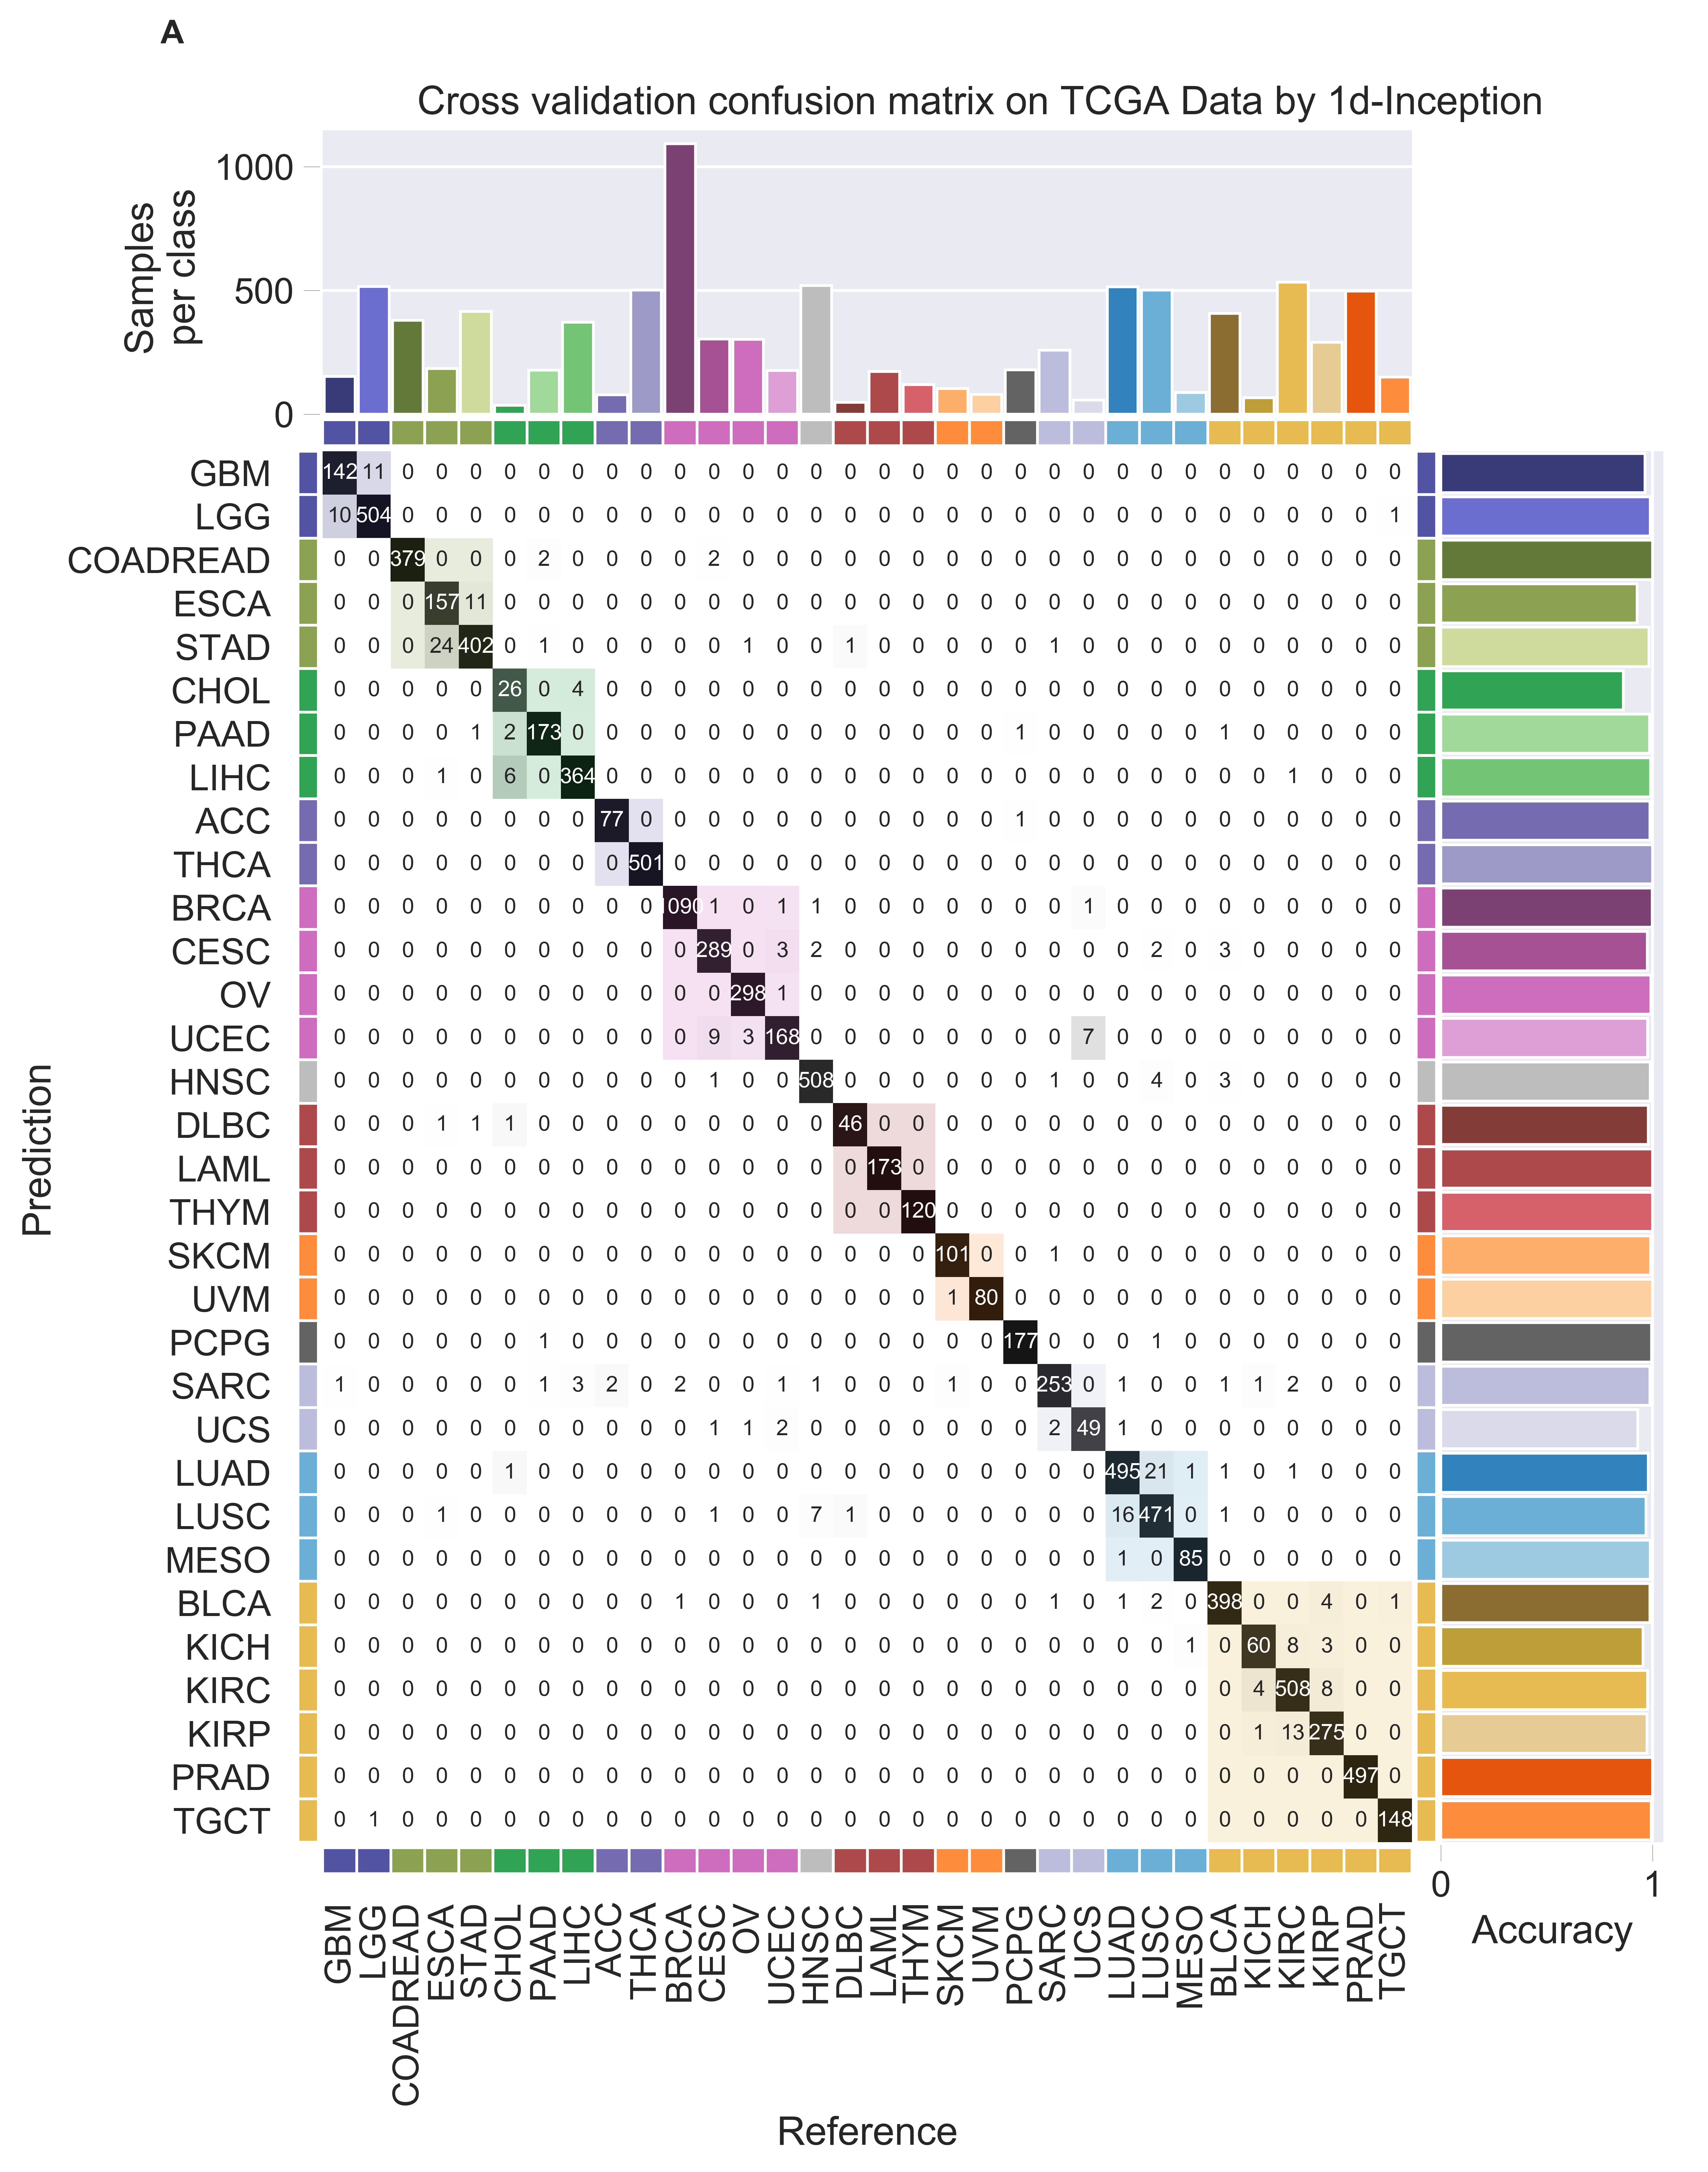

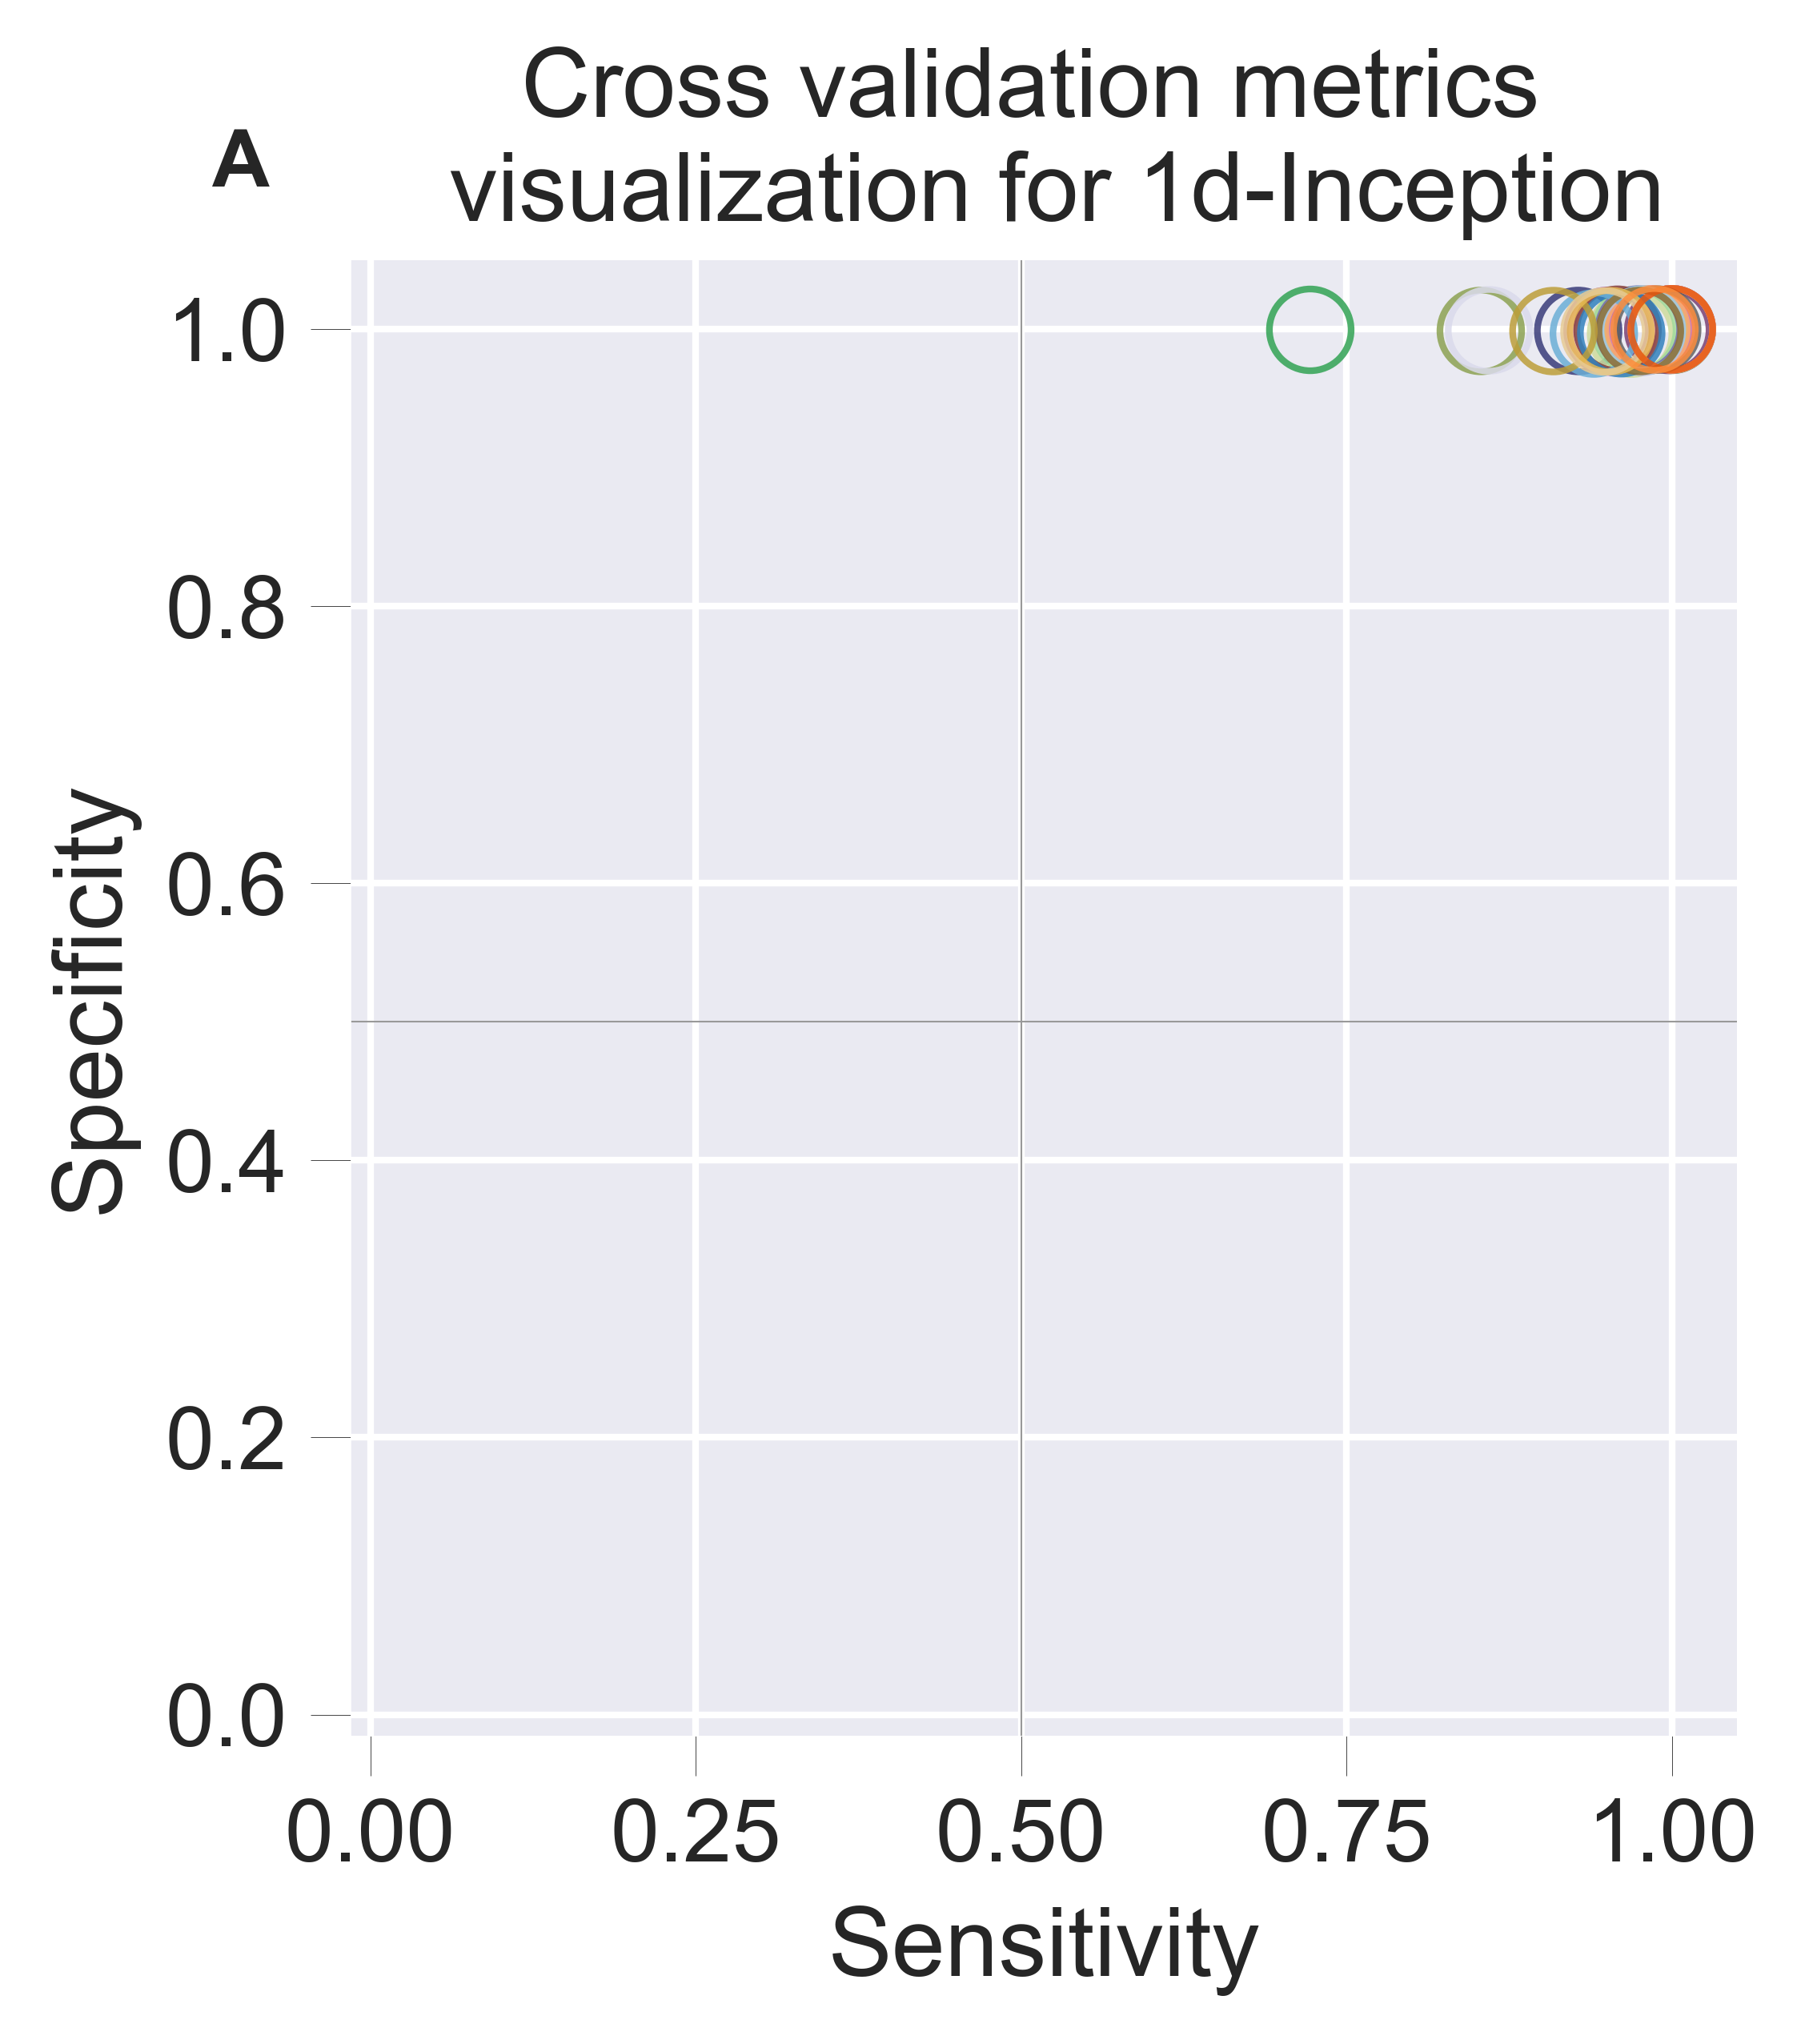

In [42]:
###CV visual
table = read_table(table_file)
table = sort_rectangular_table(clean_table(table), primary_data.index)

metrics = read_metrics(metrics_file)
metrics = metrics.loc[table.index, :]#['pos pred value', 'sensitivity', 'specificity']]

# # combine COAD AND READ into SRC
# table, metrics = combine_cancers(table, metrics, ['COAD','READ'], 'CRC')
print(metrics.median(axis=0))
print(np.diag(table).sum() / table.values.sum())


colors_x, colors_y = get_heatmap_colors(table, primary_data, 'hue', other_col=None)
colors_x_bar, colors_y_bar = get_heatmap_colors(table, primary_data, 'shade', other_col=None)
sizes = np.ones(len(colors_x)) * 150

# samples per class
marginal_x = table.sum(axis=0)
#marginal_y = metrics['pos pred value'].values
marginal_y = metrics['balanced accuracy'].values

fig, heatmap_ax1 = setup_fig(FIG_WIDTH_2COL, 1.2*FIG_HEIGHT_MAX)

marginal_heatmap(heatmap_ax1, table, marginal_x, marginal_y, 
                 colors_x, colors_y, colors_x_bar, colors_y_bar,
                 marg_ylabel='Accuracy', annotate_size=8, title='Cross validation confusion matrix on TCGA Data by '+model)
#print(metrics)
fig.savefig(model+'CvCmVisualization.png', dpi=600)

fig, scatter_ax1 = setup_fig(0.6*FIG_WIDTH_1COL, 0.7*FIG_WIDTH_1COL)
metrics_scatter(scatter_ax1, metrics, colors_x, sizes, legend_cols=25, show_legend=False,
                metrics=['sensitivity', 'specificity'], title='Cross validation metrics \n visualization for '+model)

fig.savefig(model+'CvMetricVisualization.png', dpi=600)

In [49]:
# Load Data Meta
model='1d-Inception'
table_file = '../contingency_table_Confusion_matrix_Meta_InceptionNet1d_diverse_DEG_Feature_40_deep_orderChromo_scan.csv'
metrics_file = '../preformance_metrics_Confusion_matrix_Meta_InceptionNet1d_diverse_DEG_Feature_40_deep_orderChromo_scan.csv'

# model='1d-CNN'
# table_file = '../contingency_table_Confusion_matrix_Meta_CNN1d_DEG_Feature_40_smote_OrderChromo.csv'
# metrics_file = '../preformance_metrics_Confusion_matrix_Meta_CNN1d_DEG_Feature_40_smote_OrderChromo.csv'

# model='ResNet'
# table_file = '../contingency_table_Confusion_matrix_Meta_ResNet_DEG_Feature_1000_smote_orderChromo_Best.csv'
# metrics_file = '../preformance_metrics_Confusion_matrix_Meta_ResNet_DEG_Feature_1000_smote_orderChromo_Best.csv'


sensitivity             1.000000
specificity             1.000000
pos pred value          1.000000
neg pred value          1.000000
precision               1.000000
recall                  1.000000
f1                      0.983146
prevalence              0.005076
detection rate          0.003807
detection prevalence    0.003807
balanced accuracy       0.999362
dtype: float64
0.9759358288770054


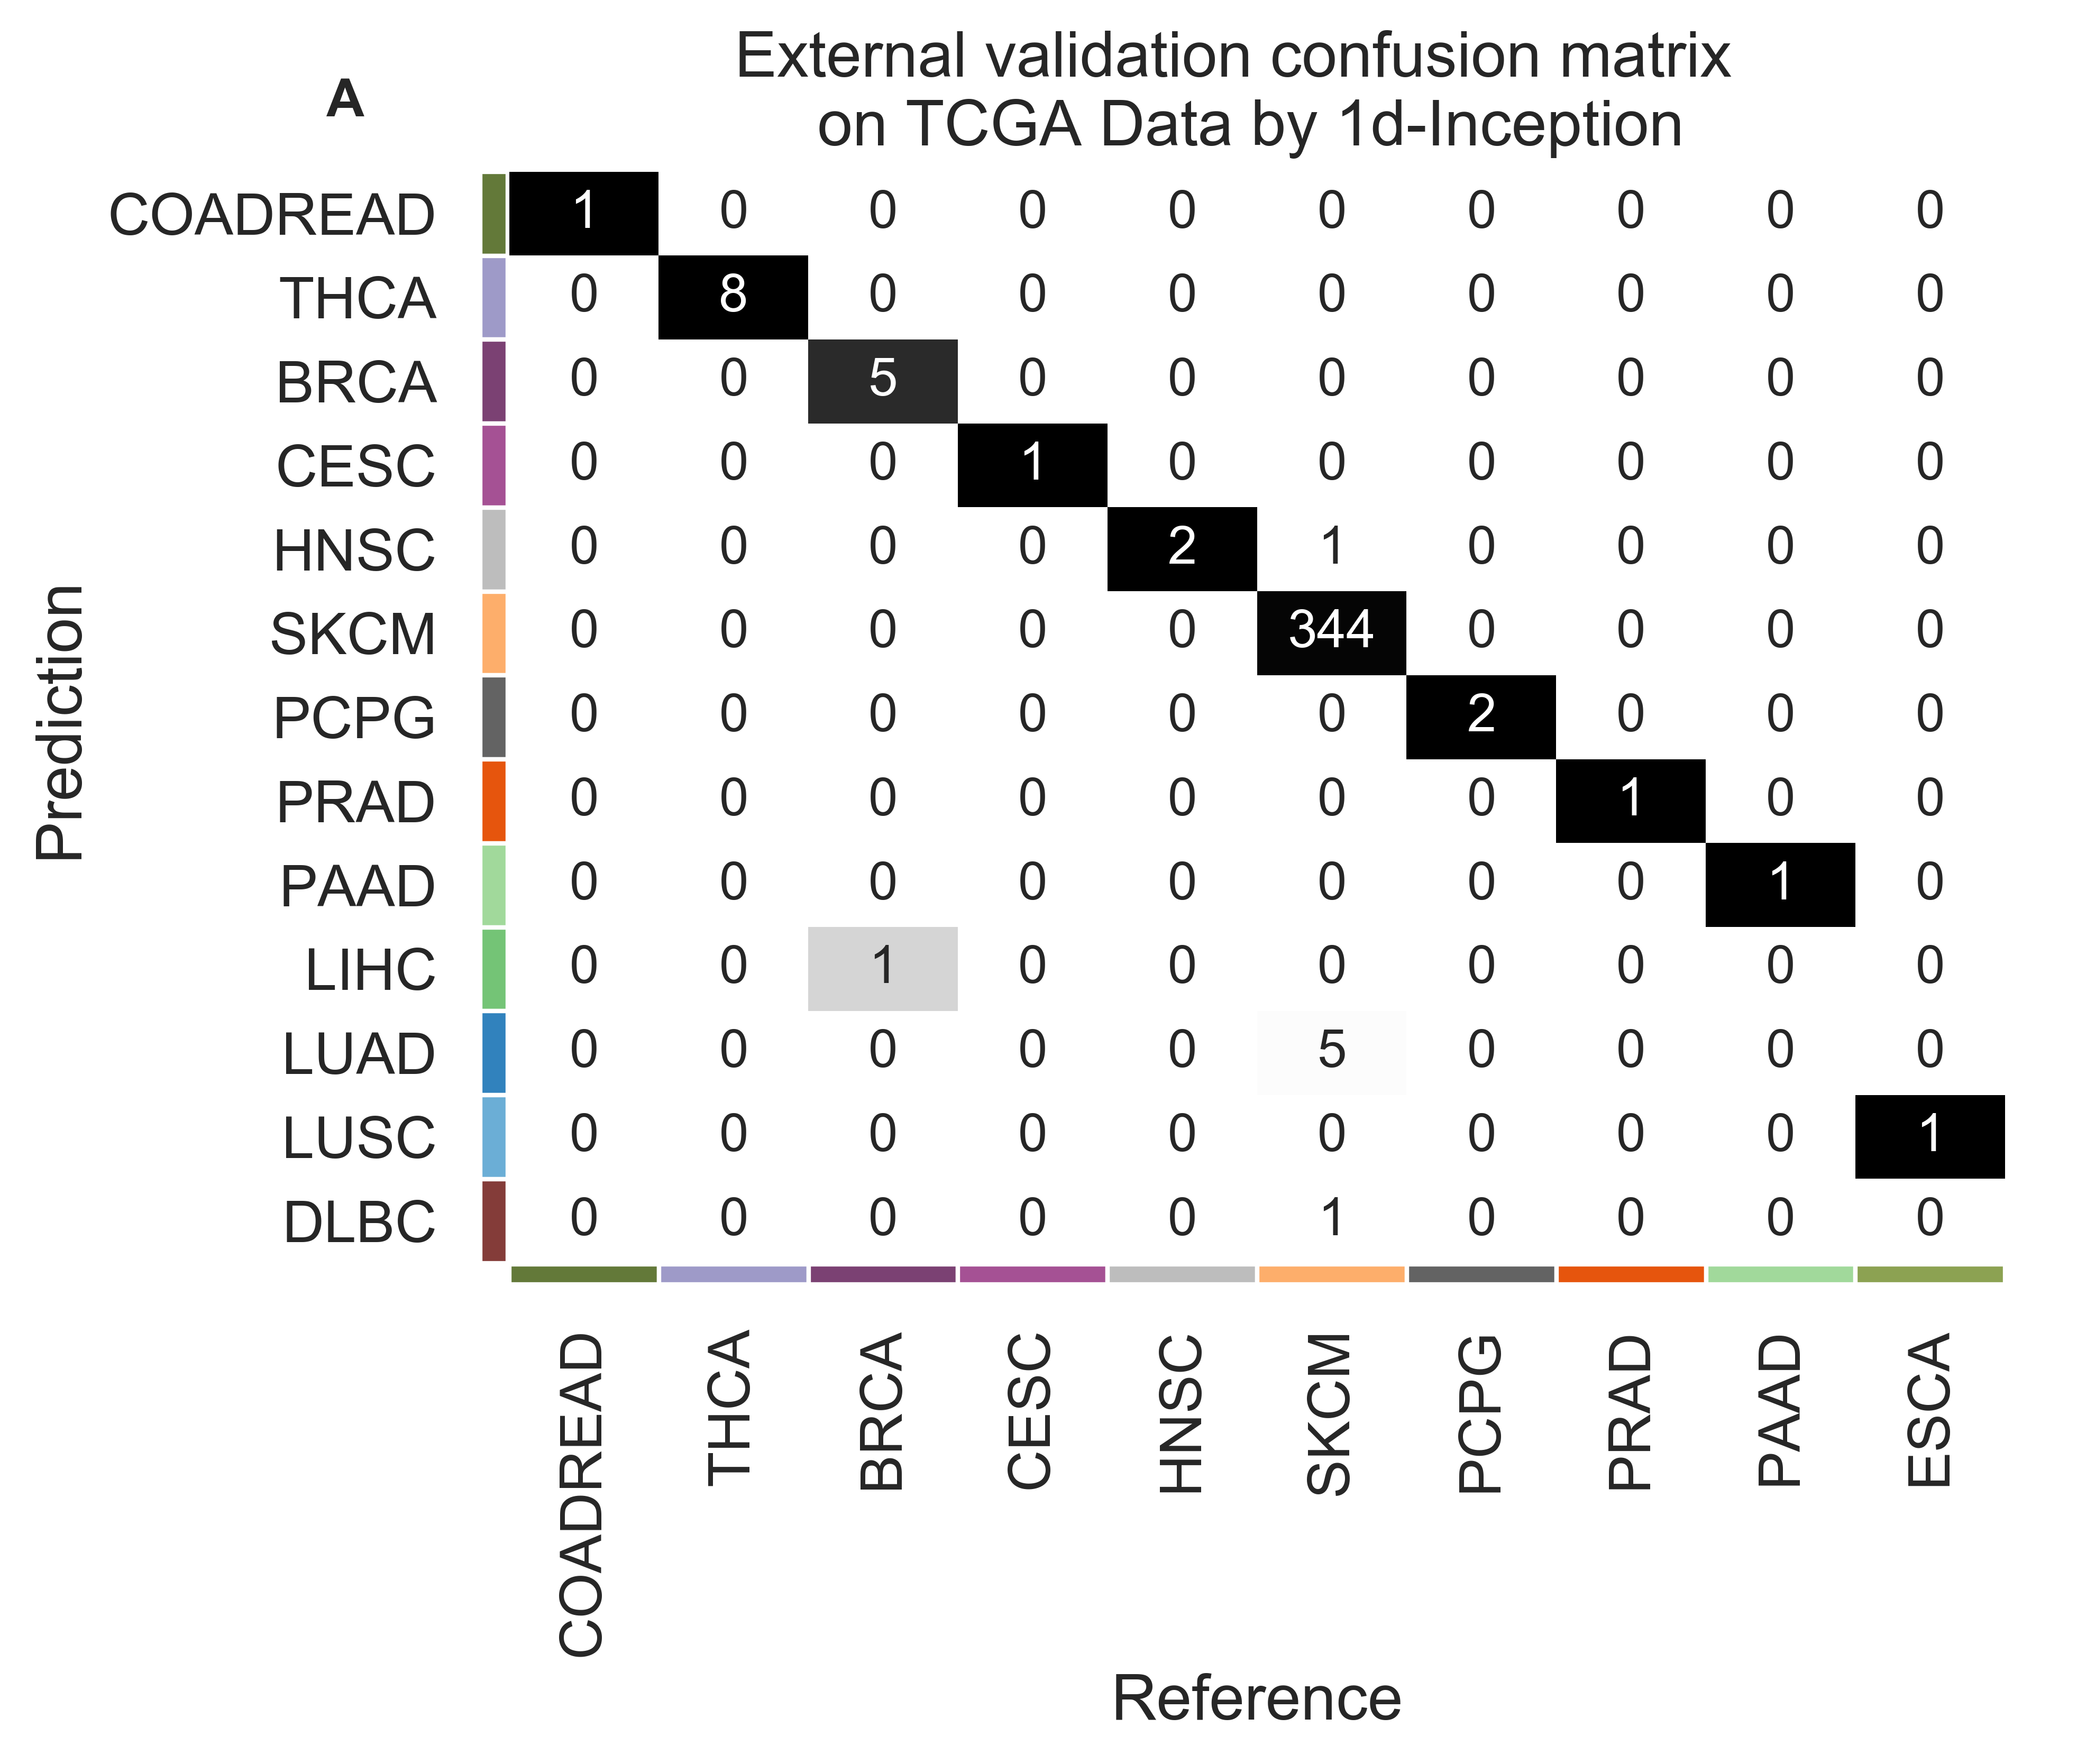

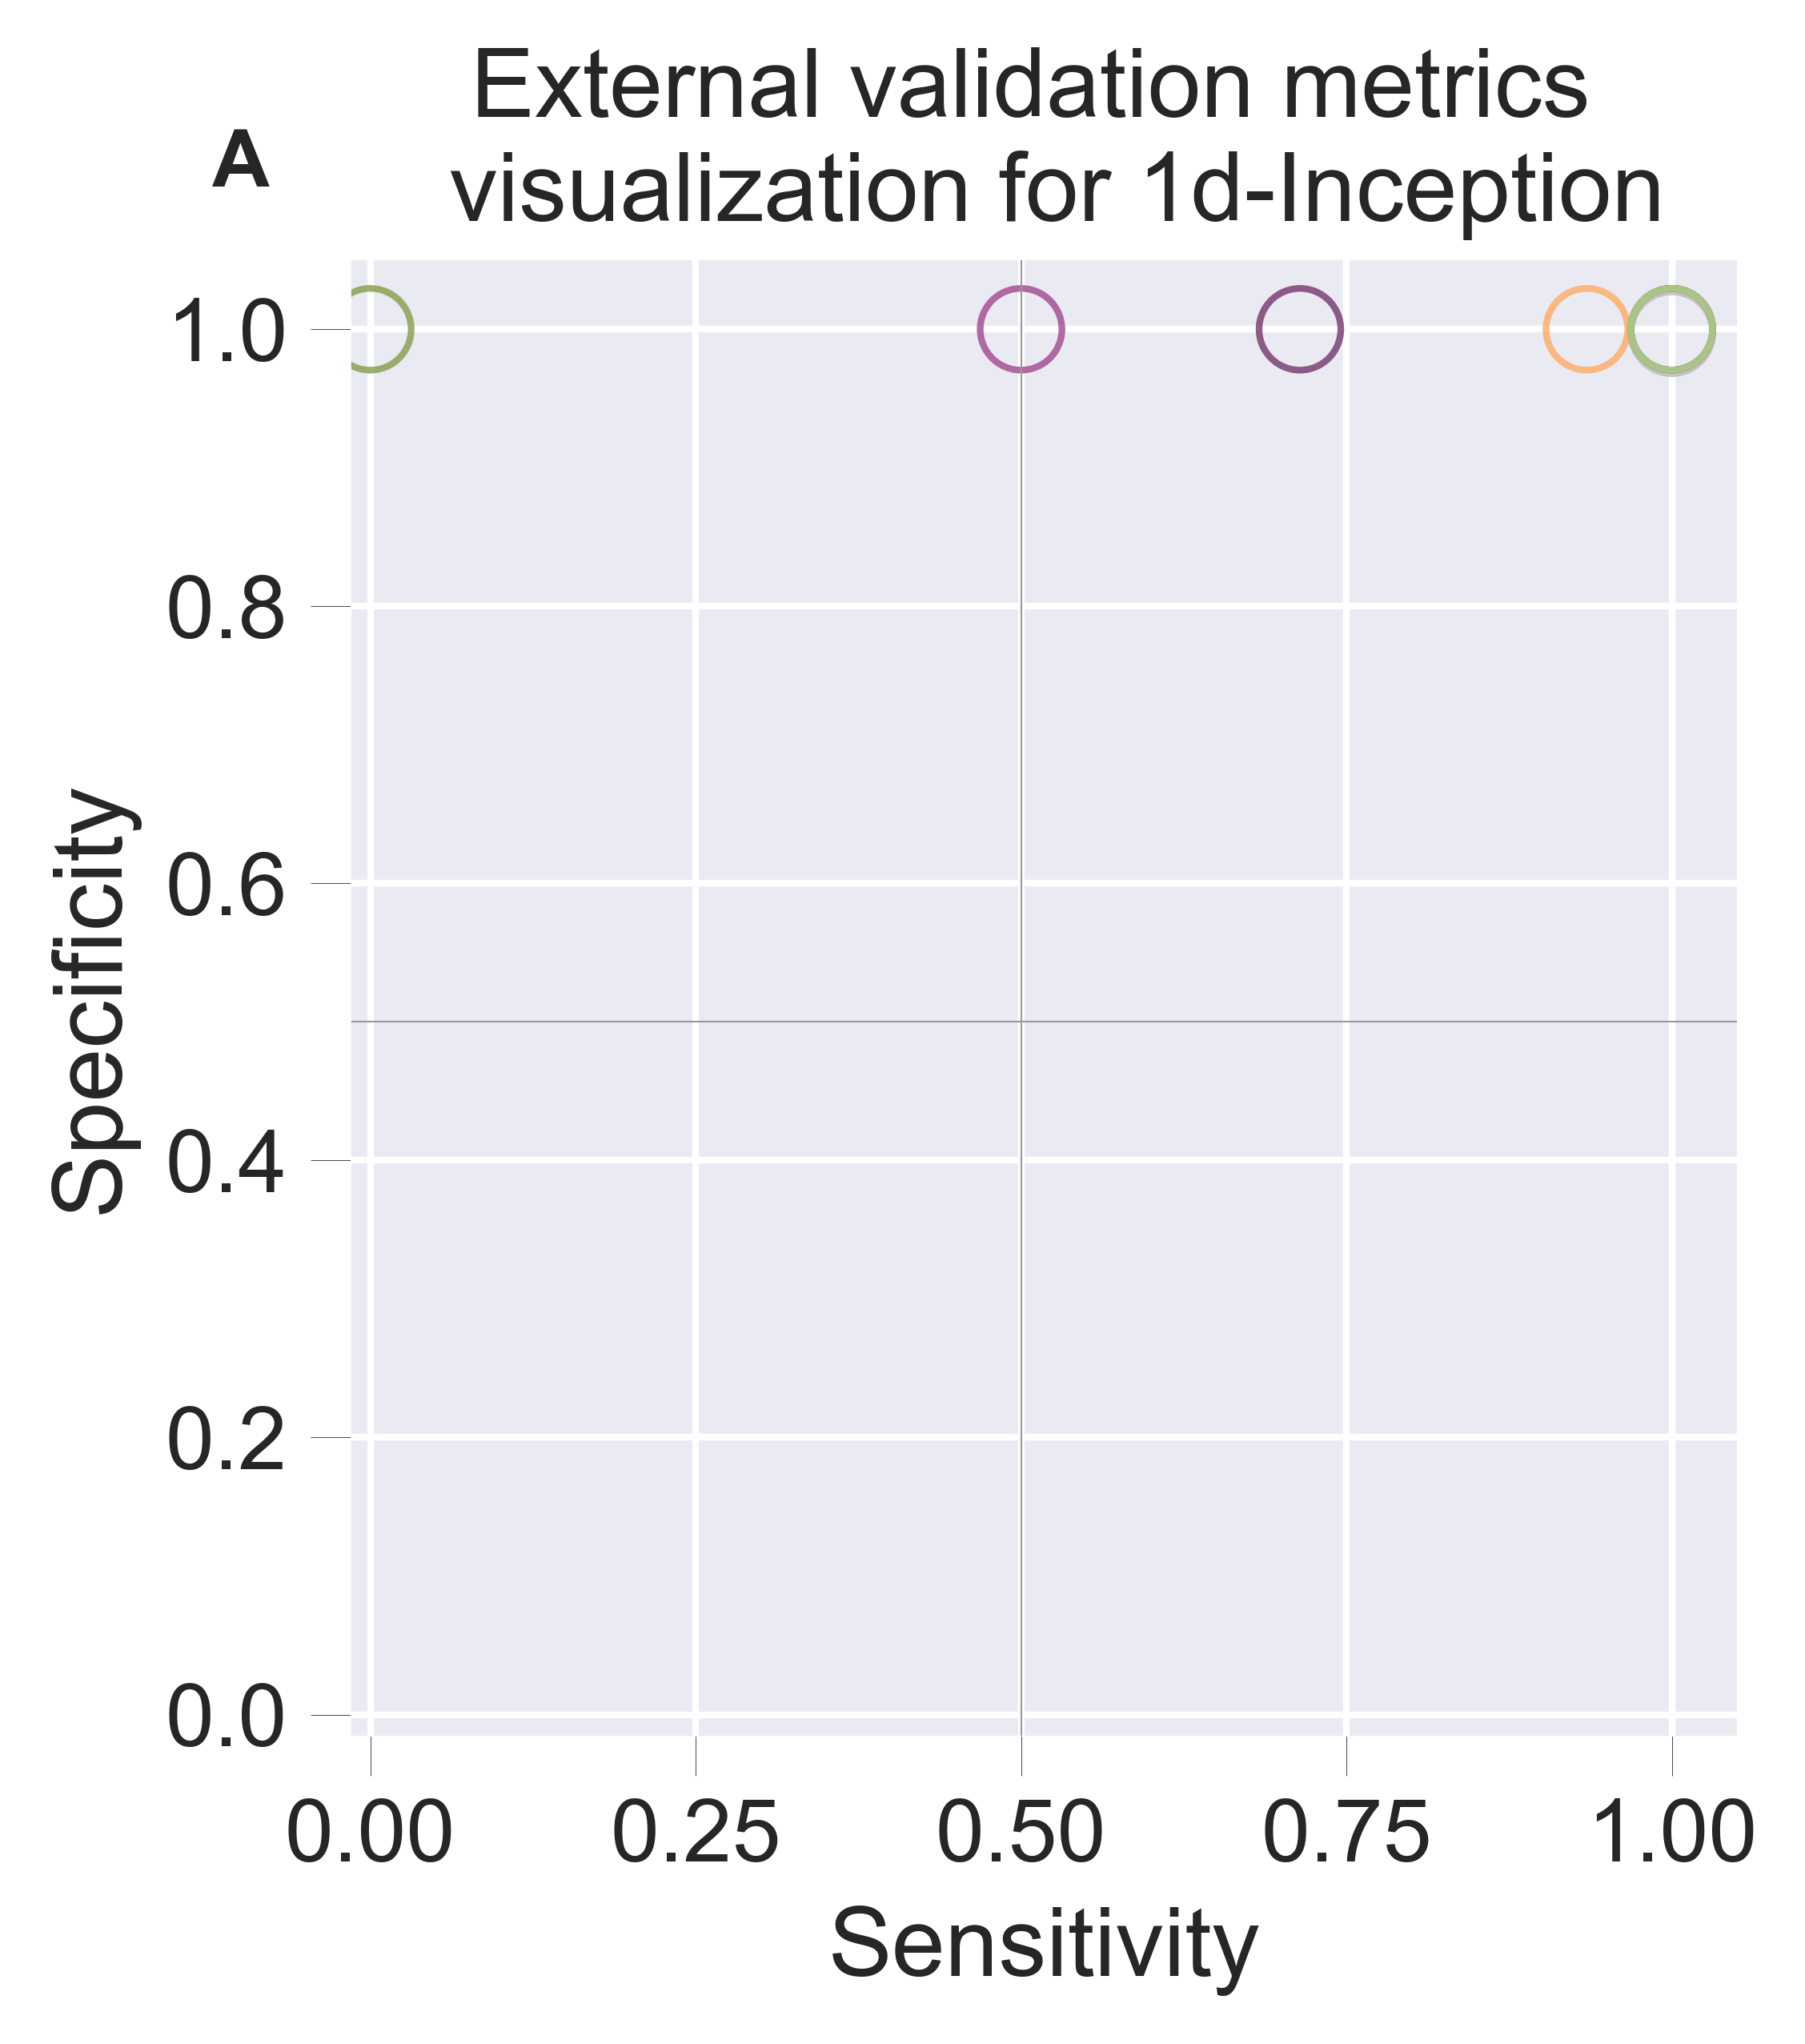

In [77]:
#Meta Visualization
table = read_table(table_file)
#print(table)
new_index = ['COADREAD','THCA', 'BRCA','CESC','HNSC','SKCM','PCPG','PRAD','PAAD','ESCA','STAD','LIHC','LUAD','LUSC','ACC','DLBC','UCS']
table = sort_rectangular_table(clean_table(table), new_index)



metrics = read_metrics(metrics_file)
metrics = metrics.loc[table.columns, :]#['pos pred value', 'sensitivity', 'specificity']]
###index is prediction, column is real class

# # combine COAD AND READ into SRC
# table, metrics = combine_cancers(table, metrics, ['COAD','READ'], 'CRC')
print(metrics.median(axis=0))
print(np.diag(table).sum() / table.values.sum())


colors_x, colors_y = get_heatmap_colors(table, primary_data, 'hue', other_col=None)
# colors_x_bar, colors_y_bar = get_heatmap_colors(table, primary_data, 'shade', other_col=None)

sizes = np.ones(len(colors_x)) * 150

# samples per class
marginal_x = table.sum(axis=0)
#marginal_y = metrics['pos pred value'].values
marginal_y = metrics['balanced accuracy'].values

fig, heatmap_ax2 = setup_fig(FIG_WIDTH_1COL, 0.8*FIG_WIDTH_1COL)
annotated_heatmap(heatmap_ax2, table, colors_x, colors_y, annotate_size=12, title='External validation confusion matrix \n on TCGA Data by '+model)

fig.savefig(model+'MetaCmVisualization.png', dpi=600)

fig, scatter_ax2 = setup_fig(0.6*FIG_WIDTH_1COL, 0.7*FIG_WIDTH_1COL)
metrics_scatter(scatter_ax2, metrics, colors_x, sizes, legend_cols=25, show_legend=False,
                metrics=['sensitivity', 'specificity'], title='External validation metrics \n visualization for '+model)
fig.savefig(model+'MetaMetricVisualization.png', dpi=600)

In [76]:
umap_data = read_table('umap_2d.csv')
umap_data['hue'] = umap_data.label.map(lambda lab: primary_data.loc[lab, 'hue'])
umap_data['shade'] = umap_data.label.map(lambda lab: primary_data.loc[lab, 'shade'])

In [13]:
primary_data.groupby?
umap_data = umap_data.loc[umap_data.label.apply(lambda i: primary_data.index.get_loc(i)).sort_values().index, :]

In [14]:
from adjustText import adjust_text

In [28]:
fig, ax = plt.subplots(figsize=(FIG_WIDTH_2COL, FIG_WIDTH_2COL))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
labels, handles = [], []
xs, ys, texts = [], [], []
for lab, inds in umap_data.groupby('label', sort=False):
    #if lab not in ['STAD', 'READ', 'COAD', 'ESCA']: continue
    #if lab not in ['LUSC', 'CESC', 'BLCA', 'ESCA']: continue
    #if lab not in ['OV', 'SARC', 'UCS', 'UCEC']: continue
    #if lab not in ['KIRC', 'KIRH', 'KIRP']: continue
    scat = ax.scatter(inds['x'], inds['y'], edgecolors=inds['hue'], s=2,
                      lw=0.2, alpha=1, facecolors='none')
    cx = inds['x'].median()
    cy = inds['y'].median()
    xs.append(cx)
    ys.append(cy)
    texts.append(plt.text(cx, cy, lab, size=4*TICK_TEXT_SIZE, color='0.2'))
    
    if lab not in labels:
        labels.append(lab)
        handles.append(scat)
        
adjust_text(texts, xs, ys, expand_points=(1.5, 1.5), force_points=1)

e1 = mpatches.Ellipse(xy=(13, 1), width=3.5, height=5, angle=-45, 
                      facecolor='none', edgecolor='g', alpha=0.4, ls='--', lw=0.5)
e2 = mpatches.Ellipse(xy=(1.5, 7.5), width=5, height=8, angle=0, 
                      facecolor='none', edgecolor='b', alpha=0.4, ls='--', lw=0.5)
e3 = mpatches.Ellipse(xy=(8, -9), width=3.5, height=4, angle=-30, 
                      facecolor='none', edgecolor='m', alpha=0.4, ls='--', lw=0.5)
[ax.add_patch(ee) for ee in (e1, e2, e3)]

leg = Legend(ax, handles, labels, ncol=1, bbox_to_anchor=(1.05, 0.5), loc='center left', fontsize='large')
for handle in leg.legendHandles:
    handle._sizes = [30]
    handle._facecolors = handle._edgecolors
ax.add_artist(leg)
ax.set_aspect('equal')
#fix_spines(ax, [])
fig.savefig('umap_visualization.png', dpi=800)